# SOME SIMPLE EXAMPLES USING THE ABC REJECTION SAMPLER

In [13]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
from functools import partial
from copy import deepcopy

In [14]:
# DEFINE OUR REJECTION SAMPLER
def rejection_sampler(x_obs, prior, simulator, epsilon, n_samples, update_freq = 100, **kwargs):
    
    # Initializations ----
    accepted_samples_cnt = 0
    total_samples_cnt = 0
    
    if (type(x_obs) == float) or (type(x_obs) == int):
        size = 1
    else: 
        size = x_obs.shape[0]
    
    if type(prior(size = 1)) == float or (type(prior(size = 1)) == int):
        params_dim = 1
    else:
        params_dim = prior(size = 1).shape[0]

    if 'n' in kwargs:
        dataset_size = kwargs['n']
    else:
        dataset_size = size

    accepted_params = np.zeros((n_samples, params_dim))
    # ---------------------
    
    # Main loop --> get posterior samples until we have n_samples of them
    while accepted_samples_cnt < n_samples:
        params_tmp = prior(size = 1)
        x_sim = simulator(params = params_tmp, size = size, **kwargs)
        # ACCEPT / REJECT STEP
        if np.sum(np.abs(x_sim - x_obs)) <= epsilon: # We accept a sample only if it is whitin epsilon of the true data
            accepted_params[accepted_samples_cnt, :] = params_tmp
            accepted_samples_cnt += 1
            
            if (accepted_samples_cnt % update_freq) == 0: 
                print('{} of {} samples gathered...'.format(accepted_samples_cnt, n_samples))
        total_samples_cnt += 1
    # --------------------------------------------------------------------
    
    print('Accepted / Total Samples for Epsilon {} and Dataset-size {}: {}'.format(epsilon_tmp, dataset_size, accepted_samples_cnt / total_samples_cnt))
    return accepted_params

## NOTES

The problem setup is always going to be, 

1. We have some **empirical data** --> `x_obs`

2. We have a **prior distribution** --> `prior`

3. We have a **simulator** --> `simulator_{name}`

4. For our examples (in the real world you don't) we have **samples from the true posterior** --> `true_post`


Then we use the **ABC Rejection Sampler**, with tolerance level `epsilon` to get posterior samples via our **simulator**.



# EXAMPLE: SINGLE DATAPOINT FROM A NORMAL, VARY EPSILON

In [15]:
# EMPIRICAL DATA
x_obs = np.random.normal(0, 1)

In [16]:
x_obs

1.2426285701370139

In [17]:
# # EMPIRICAL DATA
# x_obs = np.random.normal(0, 1)

# TRUE POSTERIOR
true_post = np.random.normal(x_obs, 1, size = 2000)

# PRIOR
prior = partial(np.random.uniform, **{'low': -10, 'high': 10})

# SIMULATOR
def simulator_normal_mean(params = 0, size = 1):
    assert (type(params) == float) or (params.shape[0] == 1), 'Simulator takes in single parameter, you supplied the wrong data format and / or at least two parameters'
    return np.random.normal(params, 1, size = size)

# GET REJECTION SAMPLES FOR MULTIPLE EPSILONS
n_samples_to_get = 2000
epsilons = [0.1, 0.5, 1.0, 2.0, 4.0]
accepted_samples = []

for epsilon_tmp in epsilons:
    accepted_samples.append(rejection_sampler(x_obs = x_obs, 
                                              prior = prior, 
                                              simulator = simulator_normal_mean, 
                                              epsilon = epsilon_tmp, 
                                              n_samples = n_samples_to_get,
                                              update_freq = 1000))
    
accepted_samples = np.column_stack(accepted_samples) #.reshape(-1, n_samples_to_get)

1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.1 and Dataset-size 1: 0.009959415382317057
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.5 and Dataset-size 1: 0.05080913548255976
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 1.0 and Dataset-size 1: 0.09715812484819043
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 2.0 and Dataset-size 1: 0.1968697706467172
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 4.0 and Dataset-size 1: 0.39992001599680066


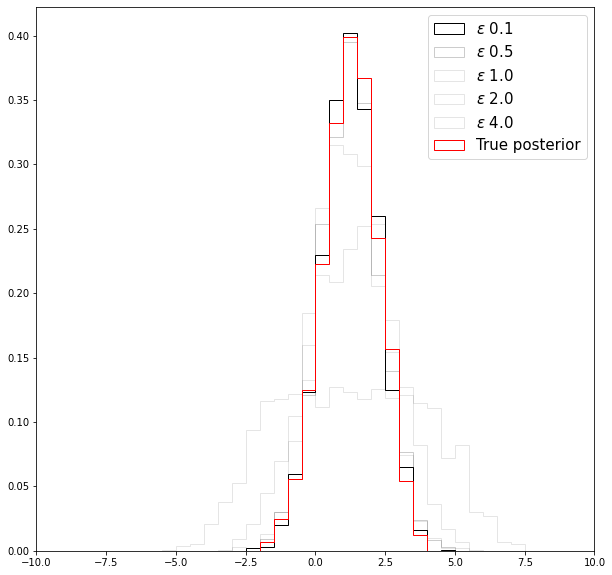

In [18]:
# PLOTTING

# Plot epsilon-wise ABC posteriors
epsilon_cnt = 0
plt.figure(figsize = (10, 10))
for epsilon_tmp in epsilons:
    plt.hist(accepted_samples[:, epsilon_cnt], 
             histtype = 'step', 
             color = 'black', 
             density = True,
             alpha = max(0.1, (1 / epsilon_tmp) / (np.max(1 / np.array(epsilons)))),
             range = (-10, 10),
             bins = 40, 
             label = r'$\epsilon$ ' + str(epsilon_tmp))
    plt.xlim((-10, 10))
    epsilon_cnt += 1

# Plot true posterior
plt.hist(true_post, histtype = 'step', 
         color = 'red', 
         density = True,
         range = (-10, 10),
         alpha = 1.0, 
         bins = 40, 
         label = 'True posterior')
plt.legend(loc = 'upper right', prop = {'size': 15})

# EXAMPLE: SINGLE BERNOULLI TRIAL, VARY EPSILON

In [21]:
# EMIRICAL DATA
x_obs = np.array([1.0])

In [22]:
x_obs

array([1.])

In [23]:
# EMIRICAL DATA
x_obs = np.array([1.0])

# TRUE POSTERIOR
true_post = np.random.beta(1 + x_obs, 1 + (1 - x_obs), size = 2000)

# PRIOR 
prior = partial(np.random.beta, **{'a': 1, 'b': 1})


# SIMULATOR
def simulator_bernoulli(params = 0, size = 1):
    assert (type(params) == float) or (params.shape[0] == 1), 'Simulator takes in single parameter, you supplied the wrong data format and / or at least two parameters'
    return np.random.binomial(1, params, size = size)



# GET REJECTION SAMPLES FOR MULTIPLE EPSILONS
n_samples_to_get = 2000
epsilons = [0.1, 0.5, 1.0, 2.0]
accepted_samples = []

for epsilon_tmp in epsilons:
    accepted_samples.append(rejection_sampler(x_obs = x_obs, 
                                              prior = prior, 
                                              simulator = simulator_bernoulli, 
                                              epsilon = epsilon_tmp, 
                                              n_samples = n_samples_to_get,
                                              update_freq = 1000))
    
accepted_samples = np.column_stack(accepted_samples) #.reshape(-1, n_samples_to_get)

1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.1 and Dataset-size 1: 0.501002004008016
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.5 and Dataset-size 1: 0.5005005005005005
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 1.0 and Dataset-size 1: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 2.0 and Dataset-size 1: 1.0


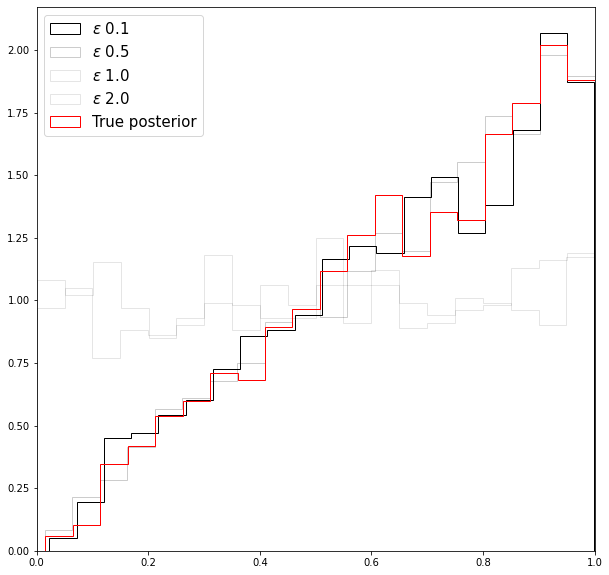

In [24]:
# PLOTTING
epsilon_cnt = 0
plt.figure(figsize = (10, 10))
for epsilon_tmp in epsilons:
    plt.hist(accepted_samples[:, epsilon_cnt], 
             histtype = 'step', 
             color = 'black',
             density = True,
             alpha = max(0.1, (1 / epsilon_tmp) / (np.max(1 / np.array(epsilons)))), 
             bins = 20, 
             label = r'$\epsilon$ ' + str(epsilon_tmp))
    plt.xlim((0, 1))
    epsilon_cnt += 1
plt.hist(true_post, histtype = 'step', 
         color = 'red', 
         density = True,
         alpha = 1.0, 
         bins = 20, 
         label = 'True posterior')
plt.legend(loc = 'upper left', prop = {'size': 15})

# EXAMPLE: INCREASE NUMBER OF COINFLIPS, VARY EPSILON

In [26]:
# EMPIRICAL DATA
data_lens = [1, 2, 4, 8]
x_obs = [np.random.binomial(1, 0.5, size = data_lens[i]) for i in range(len(data_lens))]


In [27]:
x_obs

[array([1]),
 array([1, 0]),
 array([0, 1, 1, 1]),
 array([1, 1, 0, 1, 1, 0, 0, 0])]

In [28]:
# # EMPIRICAL DATA
# data_lens = [1, 2, 4, 8]
# x_obs = [np.random.binomial(1, 0.5, size = data_lens[i]) for i in range(len(data_lens))]

# TRUE POSTERIOR
true_post = [np.random.beta(1 + np.sum(x_obs[i]), 1 + data_lens[i] - np.sum(x_obs[i]), size = 2000) for i in range(len(data_lens))]
 
# PRIOR 
prior = partial(np.random.beta, **{'a': 1, 'b': 1})


# SIMULATOR
def simulator_bernoulli(params = 0, size = 1):
    assert (type(params) == float) or (params.shape[0] == 1), 'Simulator takes in single parameter, you supplied the wrong data format and / or at least two parameters'
    return np.random.binomial(1, params, size = size)

# GET REJECTION SAMPLES FOR MULTIPLE EPSILONS
n_samples_to_get = 2000
epsilons = [0.0, 2.0, 4.0]
accepted_samples_multi_len = []

for i in range(len(data_lens)):
    accepted_samples = []
    for epsilon_tmp in epsilons:
        accepted_samples.append(rejection_sampler(x_obs = x_obs[i], 
                                                  prior = prior, 
                                                  simulator = simulator_bernoulli, 
                                                  epsilon = epsilon_tmp, 
                                                  n_samples = n_samples_to_get,
                                                  update_freq = 1000))

    accepted_samples_multi_len.append(deepcopy(np.expand_dims(np.column_stack(accepted_samples), 0))) #.reshape(-1, n_samples_to_get)

accepted_samples_multi_len = np.row_stack(accepted_samples_multi_len)

1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.0 and Dataset-size 1: 0.4830917874396135
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 2.0 and Dataset-size 1: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 4.0 and Dataset-size 1: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.0 and Dataset-size 2: 0.16516640515319184
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 2.0 and Dataset-size 2: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 4.0 and Dataset-size 2: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.0 and Dataset-size 4: 0.04775549188156638
1000 of 2000 samples gathered...
200

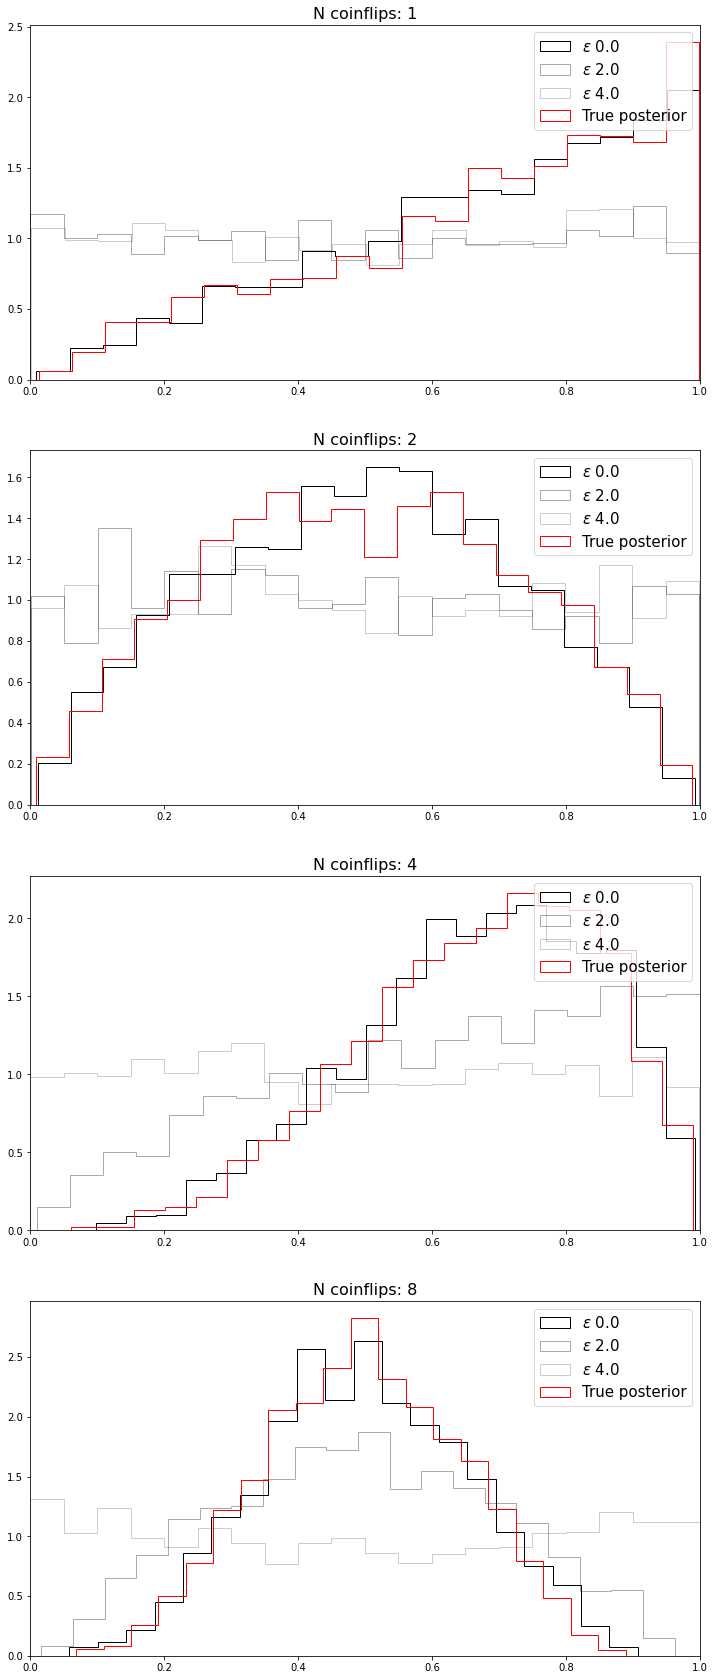

In [29]:
# PLOTTING
fig, ax = plt.subplots(len(data_lens), 1, figsize = (12, 30))

for i in range(len(data_lens)):
    epsilon_cnt = 0
    for epsilon_tmp in epsilons:
        ax[i].hist(accepted_samples_multi_len[i, :, epsilon_cnt], #epsilon_cnt, :], 
                  histtype = 'step', 
                 color = 'black', 
                 alpha = 1 / (1 + epsilon_tmp), 
                 density = True,
                 bins = 20, 
                 label = r'$\epsilon$ ' + str(epsilon_tmp))
        
        ax[i].set_xlim((0, 1))
        epsilon_cnt += 1
        
    ax[i].hist(true_post[i], histtype = 'step', 
                color = 'red', 
                alpha = 1.0, 
                density = True,
                bins = 20, 
                label = 'True posterior')
    ax[i].legend(prop = {'size': 15})
    ax[i].set_title('N coinflips: ' + str(data_lens[i]), size = 16)

## EXAMPLE: BERNOULLI WITH SUMMARY STATISTICS

It turns out that for a sequence of **Bernoulli Trials** (Coin Flips), we only need to know the **number of heads** to estimate the probability of success.

So instead of matching exact sequences of $0$'s and $1$'s, we can only focus on matching **head counts**.

This returns our probem back to a **one dimensional matching**, and we should observe much better **acceptance probabilities**. 

Lets see ....

In [30]:
# Our empirical data
data_lens = [1, 2, 4, 8, 16, 32]
x_obs = [np.random.binomial(data_lens[i], 0.5) for i in range(len(data_lens))]

# True posterior
true_post = [np.random.beta(1 + x_obs[i], 1 + data_lens[i] - x_obs[i], size = 2000) for i in range(len(data_lens))]

# PRIOR 
prior = partial(np.random.beta, **{'a': 1, 'b': 1})


# SIMULATOR
def simulator_binomial(params = 0, size = 1, **kwargs):
    assert (type(params) == float) or (params.shape[0] == 1), 'Simulator takes in single parameter, you supplied the wrong data format and / or at least two parameters'
    return np.random.binomial(kwargs['n'], params, size = 1)

# GET REJECTION SAMPLES FOR MULTIPLE EPSILONS
n_samples_to_get = 2000
epsilons = [0.0, 2.0, 4.0]
accepted_samples_multi_len = []

for i in range(len(data_lens)):
    accepted_samples = []
    for epsilon_tmp in epsilons:
        accepted_samples.append(rejection_sampler(x_obs = x_obs[i],
                                                  prior = prior, 
                                                  simulator = simulator_binomial, 
                                                  epsilon = epsilon_tmp, 
                                                  n_samples = n_samples_to_get,
                                                  update_freq = 1000,
                                                  **{'n': data_lens[i]}))

    accepted_samples_multi_len.append(deepcopy(np.expand_dims(np.column_stack(accepted_samples), 0))) #.reshape(-1, n_samples_to_get)

accepted_samples_multi_len = np.row_stack(accepted_samples_multi_len)

1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.0 and Dataset-size 1: 0.5013787916771121
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 2.0 and Dataset-size 1: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 4.0 and Dataset-size 1: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.0 and Dataset-size 2: 0.34036759700476515
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 2.0 and Dataset-size 2: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 4.0 and Dataset-size 2: 1.0
1000 of 2000 samples gathered...
2000 of 2000 samples gathered...
Accepted / Total Samples for Epsilon 0.0 and Dataset-size 4: 0.20195900232252853
1000 of 2000 samples gathered...
200

## NOTE:

We observe a great improvement in acceptance rate over matchine sequences directly, but using **low dimensional summary statistics** !

In [ ]:
# PLOTTING
fig, ax = plt.subplots(len(data_lens), 1, figsize = (12, 50))

for i in range(len(data_lens)):
    epsilon_cnt = 0
    for epsilon_tmp in epsilons:
        ax[i].hist(accepted_samples_multi_len[i, :, epsilon_cnt], 
                 histtype = 'step', 
                 color = 'black', 
                 alpha = 1 / (1 + epsilon_tmp), 
                 bins = 20, 
                 label = r'$\epsilon$ ' + str(epsilon_tmp))
        
        ax[i].set_xlim((0, 1))
        epsilon_cnt += 1
        
    ax[i].hist(true_post[i], histtype = 'step', 
                color = 'red', 
                alpha = 1.0, 
                bins = 20, 
                label = 'True posterior')
    ax[i].legend()
    ax[i].set_title('N coinflips: ' + str(data_lens[i]), size = 16)

## Notes

Low dimensional summaries of the data are important for sampling efficiency (this concept is still important for modern methods).

Standard statistical models (especially those part of the **Exponential Family**) tend to have these low dimensional summary statistics. 

The formal notion is called **Sufficient Statistic**: A low dimensional summary of the data, which *preserves all information about the parameters*. 

**Well known example**: If your data comes from a *Normal Distribution*, you can summarize it with $\hat{\mu}$, the **sample mean** and $\hat{\sigma^2}$, **the sample variance**.

# ANY QUESTIONS ABOUT THIS PART ? 